<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/Mobilenetv2_garbage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Directly using mobilenetv3 to train a neural network, it can give a very good accuracy (about 99%). On the other hand, using tranfer learning, a pre-trained mobilenetv3 model (imagenet) only provides about 86$. 

# 1. Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted at /content/drive

In [48]:
!ls "/content/drive/My Drive/Garbage classification/"


cardboard  glass  metal  paper	plastic  trash


In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Add, Reshape, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import glob, os, random
import numpy as np
import matplotlib.pyplot as plt

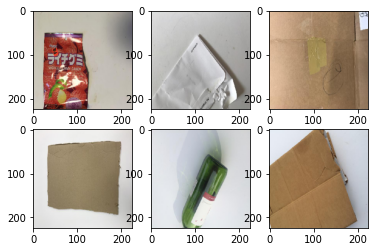

In [7]:
from keras.preprocessing import image
base_path = '/content/drive/My Drive/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [103]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 16,
    class_mode='categorical',
    subset='validation',
    seed=0
)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((16, 224, 224, 3), (16, 6))

In [10]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)



{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [11]:
!ls

drive  labels.txt  sample_data


In [12]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

# 2. Implemneting MobileNetv2 Model
Source:  https://github.com/xiaochus/MobileNetV2/blob/master/mobilenet_v2.py


In [105]:
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D
from keras.utils.vis_utils import plot_model

from keras import backend as K

In [106]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [107]:
def relu6(x):
    """Relu 6
    """
    return K.relu(x, max_value=6.0)

In [108]:
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)

In [109]:
def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        alpha: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] * t
    # Width
    cchannel = int(filters * alpha)

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = Add()([x, inputs])

    return x

In [110]:
def _inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        alpha: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, alpha, strides)

    for i in range(1, n-1):
        x = _bottleneck(x, filters, kernel, t, alpha, 1, True)

    return x

In [116]:
def MobileNetV2(input_shape, k, alpha=1.0):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        alpha: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
    # Returns
        MobileNetv2 model.
    """
    inputs = Input(shape=input_shape)

    first_filters = _make_divisible(32 * alpha, 8)
    x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)

    if alpha > 1.0:
        last_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_filters = 1280

    x = _conv_block(x, last_filters, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_filters))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)

    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)

    model = Model(inputs, output)
    # plot_model(model, to_file='images/MobileNetv2.png', show_shapes=True)

    return model

In [117]:
IMG_SHAPE = (224,224,3)
 
base_model = MobileNetV2(IMG_SHAPE, 6, 1.0)
base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation_227 (Activation)     (None, 112, 112, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [118]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),   
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [119]:
batch_size = 16
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = base_model.fit(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/50
142/142 [==============================] - 29s 203ms/step - loss: 1.5739 - acc: 0.3978 - val_loss: 1.8042 - val_acc: 0.1875
Epoch 2/50
142/142 [==============================] - 30s 209ms/step - loss: 1.2900 - acc: 0.5093 - val_loss: 1.9393 - val_acc: 0.1917
Epoch 3/50
142/142 [==============================] - 30s 210ms/step - loss: 1.2148 - acc: 0.5487 - val_loss: 2.2216 - val_acc: 0.1833
Epoch 4/50
142/142 [==============================] - 30s 213ms/step - loss: 1.1170 - acc: 0.5765 - val_loss: 2.5884 - val_acc: 0.2500
Epoch 5/50
142/142 [==============================] - 30s 209ms/step - loss: 1.1027 - acc: 0.5903 - val_loss: 1.8626 - val_acc: 0.3583
Epoch 6/50
142/142 [==============================] - 30s 210ms/step - loss: 1.0545 - acc: 0.5973 - val_loss: 2.3570 - val_acc: 0.3833
Epoch 7/50
142/142 [==============================] - 30s 211ms/step - loss: 1.0205 - acc: 0.6173 - val_loss: 2.3499 - val_acc: 0.4292
Epoch 8/50
142/142 [==============================] - 3

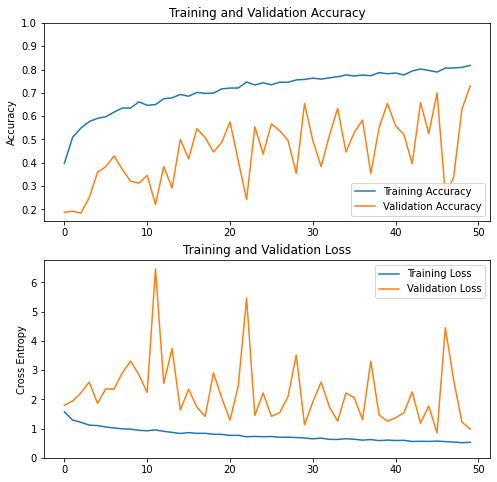

In [120]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

(1, 6)
cardboard


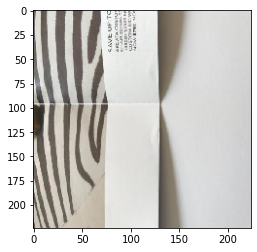

In [122]:
img_path = '/content/drive/My Drive/Garbage classification/paper/paper8.jpg'

img=np.array(img)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=base_model.predict(img[np.newaxis, ...])
print(p.shape)
predicted_class = label[np.argmax(p[0][0], axis=-1)]
print(predicted_class)

Fine Tuning MobileNetV2

In [127]:
base_model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.00001), 
              metrics=['acc'])

In [128]:
history_fine = base_model.fit(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps) 

Epoch 1/50
142/142 [==============================] - 31s 216ms/step - loss: 0.1993 - acc: 0.9257 - val_loss: 0.4779 - val_acc: 0.8125
Epoch 2/50
142/142 [==============================] - 30s 209ms/step - loss: 0.2129 - acc: 0.9257 - val_loss: 0.4610 - val_acc: 0.8292
Epoch 3/50
142/142 [==============================] - 30s 209ms/step - loss: 0.1887 - acc: 0.9279 - val_loss: 0.4688 - val_acc: 0.8250
Epoch 4/50
142/142 [==============================] - 30s 208ms/step - loss: 0.2117 - acc: 0.9221 - val_loss: 0.4934 - val_acc: 0.8208
Epoch 5/50
142/142 [==============================] - 30s 212ms/step - loss: 0.1895 - acc: 0.9274 - val_loss: 0.4903 - val_acc: 0.8125
Epoch 6/50
142/142 [==============================] - 30s 209ms/step - loss: 0.1882 - acc: 0.9314 - val_loss: 0.4860 - val_acc: 0.8042
Epoch 7/50
142/142 [==============================] - 30s 208ms/step - loss: 0.1749 - acc: 0.9398 - val_loss: 0.5060 - val_acc: 0.8083
Epoch 8/50
142/142 [==============================] - 3

In [125]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

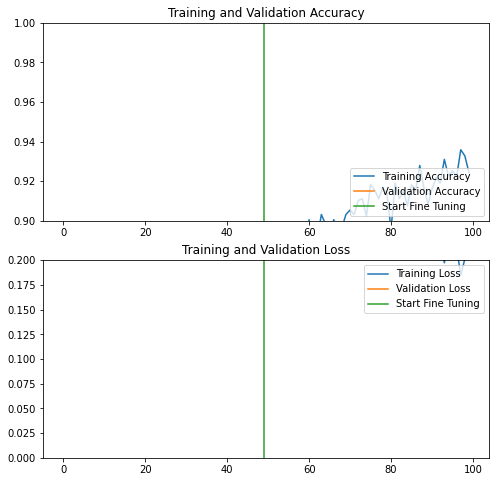

In [126]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the mobilenetv2 model

In [ ]:
model.save("mobilenetv2_garbage.h5")

## Official implementation of MobileNetv2 from Keras/applications
Source: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py

In [129]:
from keras import backend as K

In [130]:
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    in_channels = K.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = tf.keras.layers.Conv2D(expansion * in_channels,
                                      kernel_size=1,
                                      padding='same',
                                      use_bias=False,
                                      activation=None,
                                      name=prefix + 'expand')(x)
        x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = tf.keras.layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = tf.keras.layers.ZeroPadding2D(padding=correct_pad(backend, x, 3),
                                                  name=prefix + 'pad')(x)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3,
                                                strides=stride,
                                                activation=None,
                                                use_bias=False,
                                                padding='same' if stride == 1 else 'valid',
                                                name=prefix + 'depthwise')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                                  epsilon=1e-3,
                                                  momentum=0.999,
                                                  name=prefix + 'depthwise_BN')(x)

    x = tf.keras.layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = tf.keras.layers.Conv2D(pointwise_filters,
                                      kernel_size=1,
                                      padding='same',
                                      use_bias=False,
                                      activation=None,
                                      name=prefix + 'project')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                                  epsilon=1e-3,
                                                  momentum=0.999,
                                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return tf.keras.layers.Add(name=prefix + 'add')([inputs, x])
    return x

In [131]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [132]:
_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None

In [133]:
def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                **kwargs):
    """Instantiates the MobileNetV2 architecture.
    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if K.image_data_format == 'channels_first':
                if K.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if K.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            K.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not K.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and K.is_keras_tensor(input_tensor):
            if K.image_data_format() == 'channels_first':
                rows = K.int_shape(input_tensor)[2]
                cols = K.int_shape(input_tensor)[3]
            else:
                rows = K.int_shape(input_tensor)[1]
                cols = K.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if K.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if K.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = tf.keras.layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = tf.keras.layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    x = tf.keras.layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = tf.keras.layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    x = tf.keras.layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(classes, activation='softmax',
                         use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, x,
                         name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(
                model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(
                model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


In [134]:
IMG_SHAPE = (224,224,3)
base_mobilenetv2 = MobileNetV2(input_shape=IMG_SHAPE,
                    include_top=False, 
                    weights=None)
base_mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [135]:
model = tf.keras.Sequential([
  base_mobilenetv2,
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.Dropout(0.9),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 5, 5, 256)         2949376   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 256)         0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 5,208,902
Trainable params: 5,174,790
Non-trainable params: 34,112
_________________________________________________________________


In [136]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),   
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
batch_size = 16
epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs, 
                    workers=1,
                    validation_data=validation_generator, 
                    validation_steps=validation_steps)

Epoch 1/200
142/142 [==============================] - 38s 266ms/step - loss: 2.3592 - acc: 0.2350 - val_loss: 1.7817 - val_acc: 0.2042
Epoch 2/200
142/142 [==============================] - 37s 261ms/step - loss: 1.6328 - acc: 0.3230 - val_loss: 1.7814 - val_acc: 0.1583
Epoch 3/200
142/142 [==============================] - 37s 261ms/step - loss: 1.6099 - acc: 0.3673 - val_loss: 1.7723 - val_acc: 0.1917
Epoch 4/200
142/142 [==============================] - 37s 263ms/step - loss: 1.5543 - acc: 0.4022 - val_loss: 1.7723 - val_acc: 0.1917
Epoch 5/200
142/142 [==============================] - 37s 264ms/step - loss: 1.5409 - acc: 0.3841 - val_loss: 1.7713 - val_acc: 0.2000
Epoch 6/200
142/142 [==============================] - 38s 267ms/step - loss: 1.5115 - acc: 0.4088 - val_loss: 1.7712 - val_acc: 0.2000
Epoch 7/200
142/142 [==============================] - 38s 268ms/step - loss: 1.4912 - acc: 0.4376 - val_loss: 1.7682 - val_acc: 0.2042
Epoch 8/200
142/142 [===========================

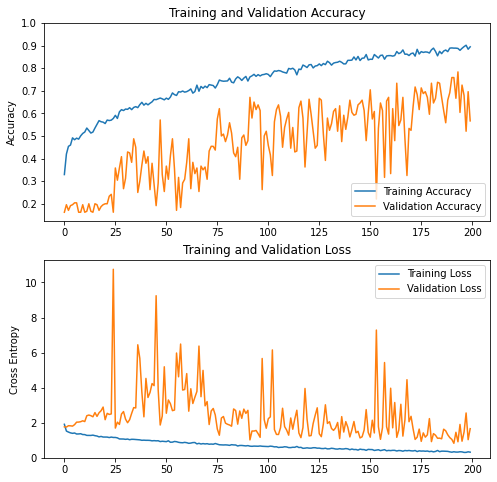

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

(1, 6)
cardboard


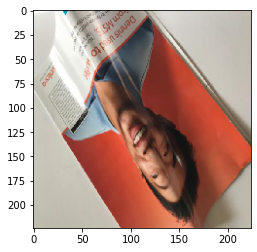

In [55]:
img_path = '/content/drive/My Drive/Garbage classification/paper/paper9.jpg'

img=np.array(img)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=model.predict(img[np.newaxis, ...])
print(p.shape)
predicted_class = label[np.argmax(p[0][0], axis=-1)]
print(predicted_class)

Fine tuning MobileNetv2

In [2]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),   
              loss='categorical_crossentropy', 
              metrics=['acc'])

NameError: ignored

In [1]:
history = model.fit(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=100, 
                              workers=1,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

NameError: ignored